In [2]:
packages <- c("survRM2", "mvtnorm", "ggplot2", "MASS", "tidyr", "survival", "nph", "tidyverse",
              "foreach", "doParallel", "cowplot", "IRdisplay", "rlang", "simtrial", "ggrepel")

install_and_load <- function(package) {
  if (!require(package, character.only = TRUE)) {
    install.packages(package)
    library(package, character.only = TRUE)
  }
}

invisible(lapply(packages, install_and_load))
n_cores <- detectCores()
cluster <- makeCluster(32)  
registerDoParallel(cluster)
# multi thread
invisible(clusterEvalQ(cluster, #import packages to parallel 
  {
  library('survRM2')
  library('mvtnorm')
  library('cubature')
  library('survival')
  library('nph')
  library("simtrial")
  library("foreach")
  }))

source('Rfiles/3m_comparison.R')
source('Rfiles/Function.R')
source('Rfiles/get_opt_des.R')
clusterExport(cluster, "expo_gen_2stages")

# Optimal Design (minimize E(N))

#### Our method need a given overall sample size N for parameter searching. 
#### So we only discuss the optimal design that minimize the expected sample size.
```math
 \bar{PET} = (PET0\ +\ PET1)\ /\ 2  \\
E_N(n) = \bar{PET} * n + (1\ -\ \bar{PET}) * N
```
#### n is the interim sample size of two groups
#### We would like to find a proper n to min(E(N)) under a given ($\alpha$, power and N)

#### The self-defined function 'get_opt_des' works for this procedure.


## 1. Proportional Hazard
####  <span style="color:yellow">Compare with optimal design of log-rank test in Jung(2017)

In [3]:
set.seed(2024)
sim_size <- 5000
N <- 111
n <- ceiling( N / 2 )  # total sample size per arm
r <- 60
acc_time <- N / r
cen_time <- 1
lambda_H0 <- 0.9 * 1.7
lambda_H1 <- 0.9
alpha <- 0.05
power <- 0.8

# sim_rmst <- get_opt_des(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
#             int_step = 2, lambda_H0 = lambda_H0, lambda_H1 = lambda_H1, H1_type = 'PH', 
#             alpha = alpha, power = power, method = 'Simple') 

our_rmst <- get_opt_des(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
            int_step = 2, lambda_H0 = lambda_H0, lambda_H1 = lambda_H1, H1_type = 'PH', 
            alpha = alpha, power = power, method = 'Complex') 
# sim_rmst
our_rmst

,m1,m2,q1,q2,gamma,PET0,PET1,alpha,power,PET,EN0,EN1,EN,interim_n
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2964,0.01781288,0.08014089,0.377004,0.7352134,0.02,0.6024,0.1862,0.0492,0.8012,0.3943,75.13312,100.6046,87.86884,51
3065,0.01781288,0.08482605,0.377004,0.7352472,0.02,0.6024,0.1862,0.0488,0.8004,0.3943,75.13312,100.6046,87.86884,51


-------------

In [13]:
set.seed(2024)
interim <- 0.6 * acc_time

data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                            cen_time = cen_time, arm = 0, interim = interim)    
    data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                            cen_time = cen_time, arm = 1, interim = interim) 
    data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H1, dist = 'exp', 
                            cen_time = cen_time, arm = 1, interim = interim)

rmst_h0_int <- RMST_sim_cal(n = n,data_E = data_E_H0[ , c(2,3,1)], 
                                data_C = data_C[ , c(2,3,1)],tau = interim, sim_size = sim_size)
            rmst_h1_int <- RMST_sim_cal(n = n,data_E = data_E_H1[ , c(2,3,1)], 
                                data_C = data_C[ , c(2,3,1)],tau = interim, sim_size = sim_size)
            rmst_h0_fin <- RMST_sim_cal(n = n,data_E = data_E_H0[ , c(4,5,1)], 
                                data_C = data_C[ , c(4,5,1)],
                                tau = acc_time + cen_time, sim_size = sim_size)
            rmst_h1_fin <- RMST_sim_cal(n = n,data_E = data_E_H1[ , c(4,5,1)], 
                                data_C = data_C[ , c(4,5,1)],
                                tau = acc_time + cen_time, sim_size = sim_size)
            rmst_data <- rbind(rmst_h0_int, rmst_h1_int, rmst_h0_fin, rmst_h1_fin)

            mu_cov_h0 <- mu_cov_mc(rmst_int = rmst_h0_int, rmst_fin = rmst_h0_fin, sim_size = sim_size)
            mu_cov_h1 <- mu_cov_mc(rmst_int = rmst_h1_int, rmst_fin = rmst_h1_fin, sim_size = sim_size)

            best_our <- adp_grid_src(rmst_data = rmst_data, mu_cov_h0 = mu_cov_h0, mu_cov_h1 = mu_cov_h1, 
                    int_n = interim * r, fin_n = N, sim_size = sim_size, method = 'Complex',
                    alpha = alpha, power = power, find_opt = TRUE)
best_our

m1,t1,m2,t2,lambda,gamma,PET0,PET1,alpha,power,EN0,EN1,EN
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>
0,0,0,0,0,0,0,0,0,0,NA,NA,NA


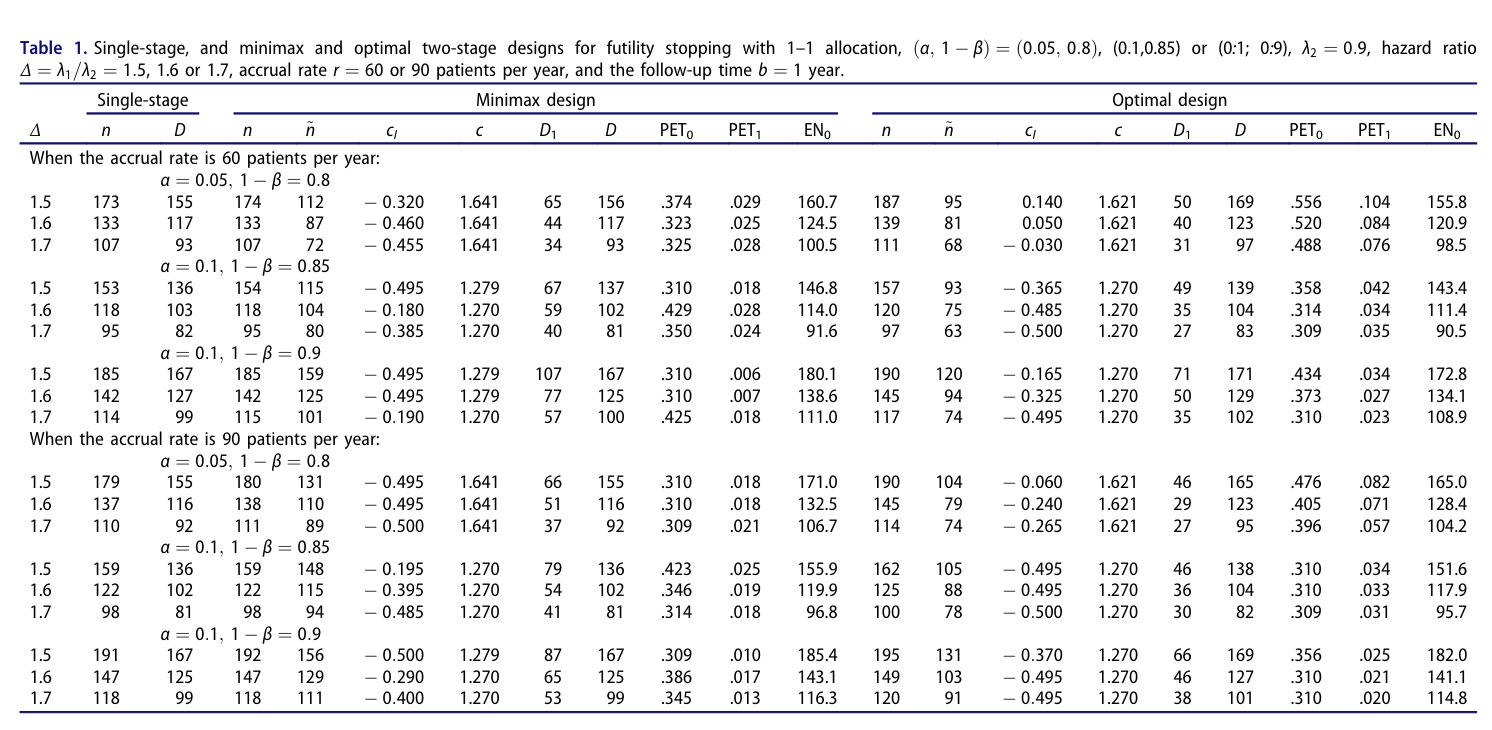

In [7]:
display_jpeg(file='figures/Jung2017_full_table1.jpeg')

get_opt_des is defined in Rfiles/get_opt_des.R.  
 We repeat this experiment to compare the EN of RMST optimal design with log rank test in table1 under different scenario.   
 The result is shown in Result/Optimal_comparison.xlsx

### <span style="color:yellow"> The optimal designs under Non proportional hazard are shown in  corrsponding ipynb files
---

## 2. Optimal Design for two-stage log-rank test

In [57]:
set.seed(2024)
sim_size <- 5000
N <- 139
n <- ceiling( N / 2 )  # total sample size per arm
r <- 60
acc_time <- N / r
cen_time <- 1
lambda_H0 <- 0.9 * 1.6
lambda_H1 <- 0.9
alpha <- 0.05
power <- 0.8

our_lr_opt <- get_opt_des(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
                int_step = 6, lambda_H0 = lambda_H0, lambda_H1 = lambda_H1, H1_type = 'PH', 
                alpha = alpha, power = power, method = 'logrank')


In [58]:
our_lr_opt

,m1,m2,PET0,PET1,alpha,power,EN0,EN1,EN,interim_n
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,-0.08709211,1.602272,0.4602,0.072,0.046,0.8004,109.6268,135.248,122.4374,74


----
# Real Example of Optimal Design
Atezolizumab versus docetaxel for patients with previously treated non-small-cell lung cancer (POPLAR): a multicentre, open-label, phase 2 randomised controlled trial
### The trial was designed with overall survival (OS) as the primary end point.  

Recruit period: 8 months
Experiment arm 144, control arm 143
Treatment start with the accrual   
Median follow-up 13 months 
HR = 0.73  
Experiment mOS = 12.6 months
Control mOS = 9.7 months 

### <span style="color:yellow"> Hypothesis: exponential proportional hazard
$$
H_0: \lambda_E = \lambda_C = log(2)/9.7 \\
H_1: \lambda_E = log(2)/12.6,\ \lambda_C = log(2)/9.7
$$

### Empirical power of one-stage log rank and RMST 

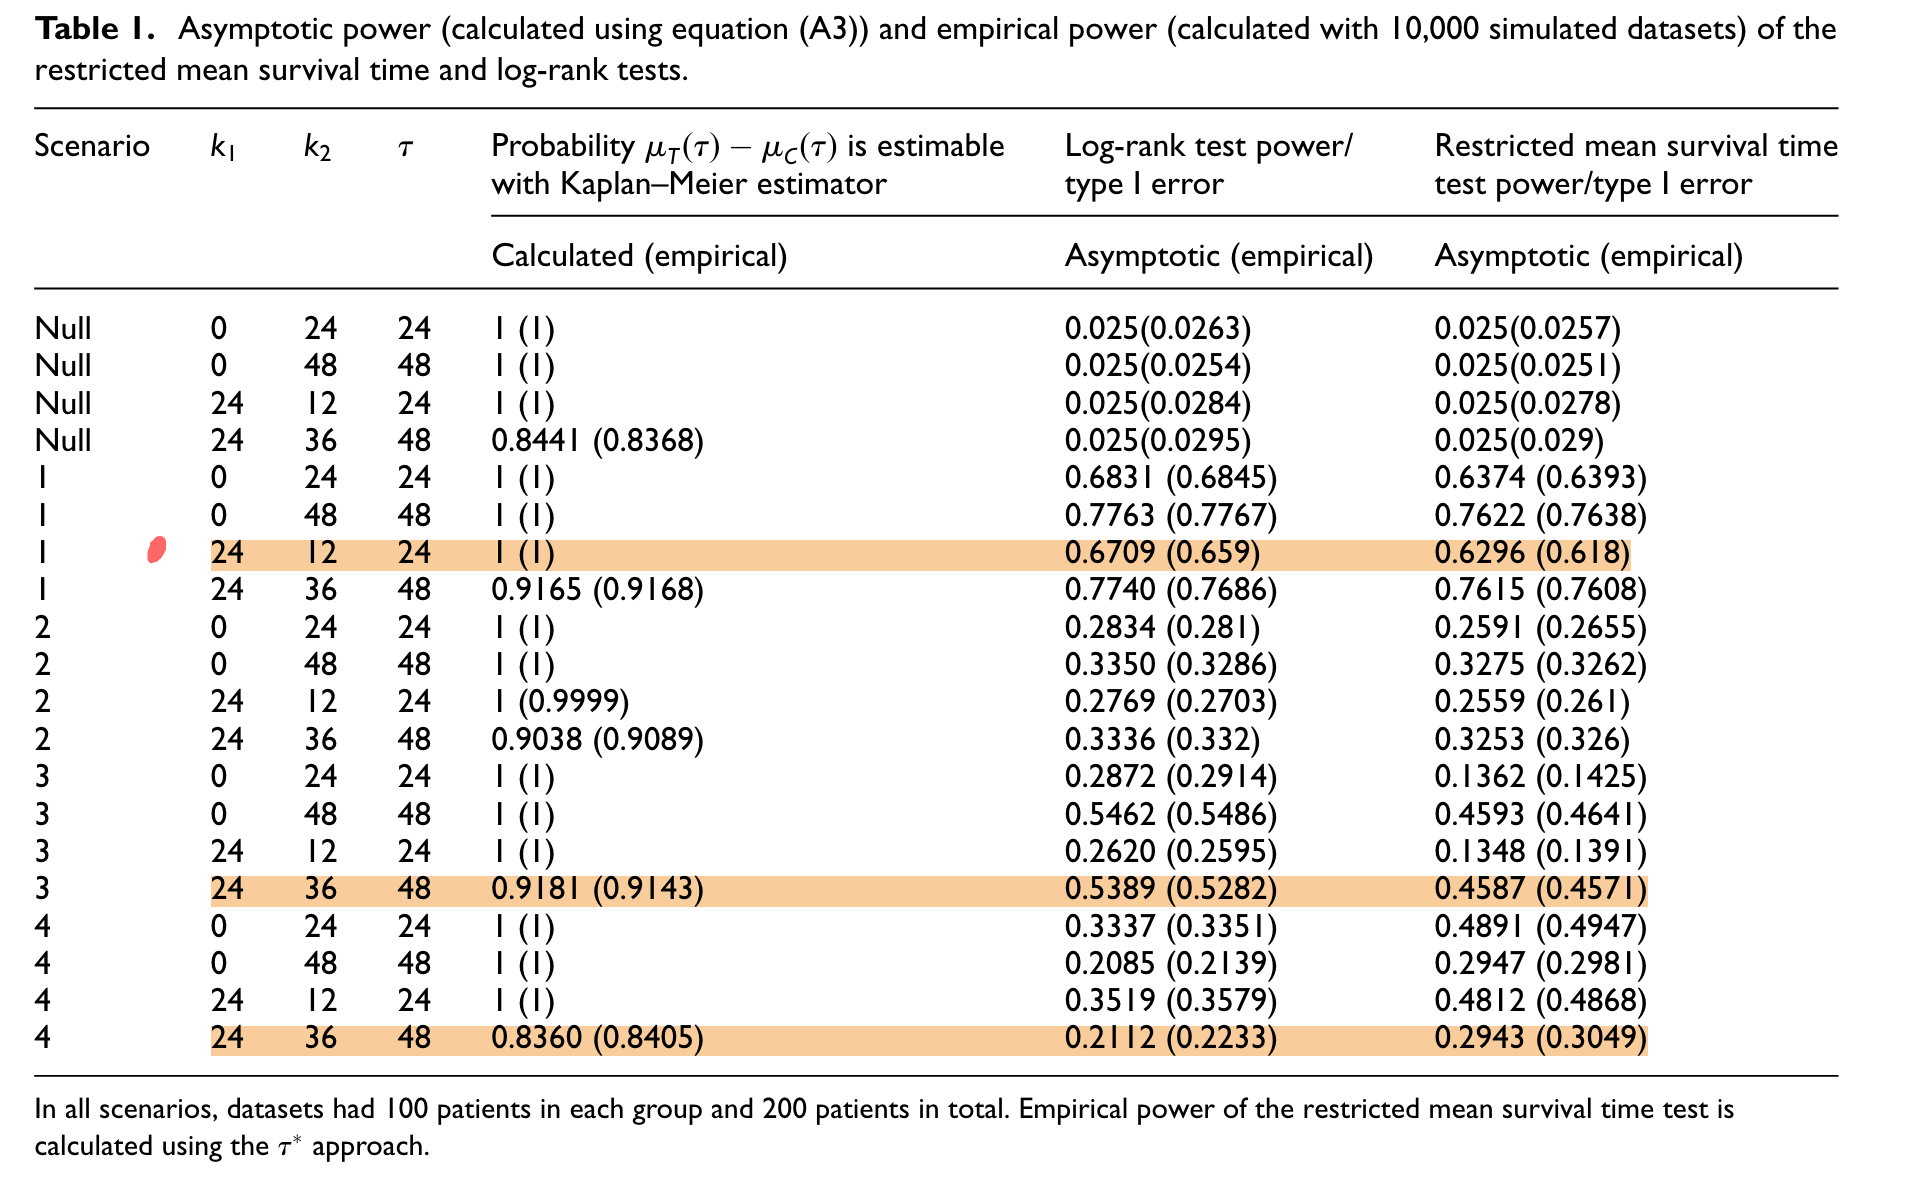

The simulated power of two-sided(alpha = 0.05) log rank test is: 0.7285 
The simulated power of two-sided(alpha = 0.05) simple rmst test is: 0.7247 
************* two sided test in Eaton 2020 *************  
The simulated power of one-sided(alpha = 0.05) log rank test is: 0.8259 
The simulated power of one-sided(alpha = 0.05) simple rmst test is: 0.8216

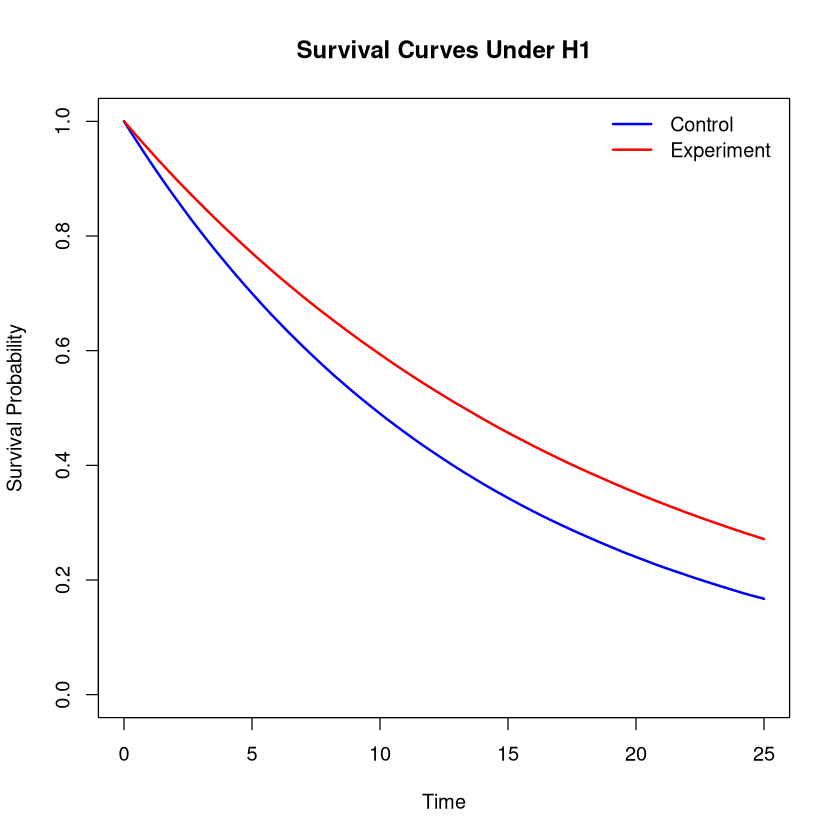

In [8]:
lambda_H0 <- log(2) / 9.7
HR <- 0.75
lambda_H1 <- lambda_H0 * HR
sim_size <- 10000
acc_time <- 15
cen_time <- 13
n <- 200
set.seed(2024)
alpha <- 0.05
tau <- acc_time + cen_time

data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                           cen_time = cen_time,arm = 0, interim = 0)[ , c(4,5,1)]    
data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                            cen_time = cen_time,arm = 1, interim = 0)[ , c(4,5,1)]
data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H1, dist = 'exp', 
                            cen_time = cen_time,arm = 1, interim = 0)[ , c(4,5,1)]  
pre_data <- rbind(data_C, data_E_H1)
fit <- survfit(Surv(pre_data[,1], pre_data[,2]) ~ pre_data[,3])
plot(fit, col = c("blue", "red"), lwd = 2, xlab = "Time", 
    ylab = "Survival Probability", main = "Survival Curves Under H1")
legend("topright", legend = c("Control", "Experiment"), 
            col = c("blue", "red"), lwd = 2, bty = "n")
# Under H1
log_rank_2 <- log_rank_sim(data_C = data_C, data_E = data_E_H1, sim_size = sim_size,
                            n = n, alpha = 0.05 ,sided = 'two_sided')
simple_rmst_2 <- RMST_sim_test(data_C = data_C, data_E = data_E_H1, sim_size = sim_size, tau = tau,
                            n = n, alpha = 0.05 ,sided = 'two_sided')
log_rank_1 <- log_rank_sim(data_C = data_C, data_E = data_E_H1, sim_size = sim_size,
                            n = n, alpha = 0.05 ,sided = 'greater')
simple_rmst_1 <- RMST_sim_test(data_C = data_C, data_E = data_E_H1, sim_size = sim_size, tau = tau,
                            n = n, alpha = 0.05 ,sided = 'greater')                          
display_jpeg(file='figures/Eaton_2020_table1.JPEG')
cat( 'The simulated power of two-sided(alpha = 0.05) log rank test is:', log_rank_2$rejection,'\n')
cat('The simulated power of two-sided(alpha = 0.05) simple rmst test is:', simple_rmst_2$test_result$rejection,'\n')
cat('************* two sided test in Eaton 2020 ************* ','\n')
cat( 'The simulated power of one-sided(alpha = 0.05) log rank test is:', log_rank_1$rejection,'\n')
cat('The simulated power of one-sided(alpha = 0.05) simple rmst test is:', simple_rmst_1$test_result$rejection)
            

----
# Real Example of Optimal Design
Atezolizumab versus docetaxel for patients with previously treated non-small-cell lung cancer (POPLAR): a multicentre, open-label, phase 2 randomised controlled trial
### The trial was designed with overall survival (OS) as the primary end point.  

Recruit period: 8 months
Experiment arm 144, control arm 143
Treatment start with the accrual   
Median follow-up 13 months 
HR = 0.73  
Experiment mOS = 12.6 months
Control mOS = 9.7 months 

### <span style="color:yellow"> Hypothesis: exponential proportional hazard
$$
H_0: \lambda_E = \lambda_C = log(2)/9.7 \\
H_1: \lambda_E = log(2)/12.6,\ \lambda_C = log(2)/9.7
$$

In [12]:
set.seed(2024)
result <- data.frame()
lambda_H0 <- log(2) / 9.7
HR <- 0.73
lambda_H1 <- lambda_H0 * HR
sim_size <- 5000
acc_time <- 8
cen_time <- 13
alpha <- 0.05
power <- 0.8
for (N in seq(from = 362, to = 378, 2))
{
    n <- ceiling(N / 2) 
    our_lr_opt <- get_opt_des(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
                int_step = 8, lambda_H0 = lambda_H0, lambda_H1 = lambda_H1, H1_type = 'PH', 
                alpha = alpha, power = power, method = 'logrank') 

    sim_rmst <- get_opt_des(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
            int_step = 8, lambda_H0 = lambda_H0, lambda_H1 = lambda_H1, H1_type = 'PH', 
            alpha = alpha, power = power, method = 'Simple')    

    our_rmst <- get_opt_des(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
            int_step = 8, lambda_H0 = lambda_H0, lambda_H1 = lambda_H1, H1_type = 'PH', 
            alpha = alpha, power = power, method = 'Complex') 
        
    res <- rbind(our_lr_opt[,3:10], sim_rmst[, 7:14], our_rmst[, 7:14])
    res$N <- c(N, N, N)
    res$Method <- c('log_rank', 'simple_rmst', 'our_rmst')
    result <- rbind(result, res)
}

In [13]:
result

,PET0,PET1,alpha,power,EN0,EN1,EN,interim_n,N,Method
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
2,0.3286,0.0494,0.0476,0.8004,325.7331,365.0445,345.3888,232,372,log_rank
10,0.5926,0.1094,0.0490,0.8048,326.4883,363.5981,345.0432,296,372,simple_rmst
101,0.6926,0.1030,0.0138,0.8120,318.8083,364.0896,341.4490,296,372,our_rmst
4,0.3568,0.0538,0.0468,0.8002,329.1859,367.2427,348.2143,249,374,log_rank
1,0.0000,0.0000,0.0000,0.0000,NA,NA,NA,NA,374,simple_rmst
9,0.7032,0.0992,0.0132,0.8170,313.8061,365.5085,339.6573,289,374,our_rmst
11,0.3334,0.0568,0.0496,0.8004,325.8566,367.4573,346.6570,226,376,log_rank
21,0.0000,0.0000,0.0000,0.0000,NA,NA,NA,NA,376,simple_rmst
102,0.7050,0.0992,0.0166,0.8160,320.7280,368.2227,344.4754,298,376,our_rmst


### If applying late difference piecewise exponential to fit the data
### Assume $HR_1 = 1$, control group follows exp dist and experiment group follows piecewise exp

In [16]:
# Solve HR2 according to the median OS of experiment group, 12.6
CT <- 3
lambda_c <- log(2) / 9.7
lambda_e1 <- lambda_c  # hazard before 4 months

# Survival function of piecewise exp
S1 <- function(t) exp(-lambda_e1 * t)
S2 <- function(t, lambda_e2) exp(-lambda_e2 * (t - CT))

# Overall survival function for the experimental group
S_overall <- function(t, lambda_e2) {
  if (t <= CT) {
    S1(t)
  } else {
    S1(CT) * S2(t, lambda_e2)
  }
}

# Find the lambda_experimental_after that gives a median OS of 12.6 months
median_target <- 12.6

# Function to find the root (when S_overall equals 0.5 at the median OS)
find_lambda_after <- function(lambda_e2) {
  S_overall(median_target, lambda_e2) - 0.5
}

# Use uniroot to solve for lambda_experimental_after
lambda_e2 <- uniroot(find_lambda_after, c(0.001, 0.1))$root
lambda_e2
lambda_e2/lambda_H0

[1] 0.04986097

[1] 0.6977614

-----